# OptTurb-Multistage

Is based on a optimization campaign to design a turbine for Purdue AeroThermal Experimental Lab. It is based on a 1D meanline code; however, the full radial equilibrium equations are solved.

The lab consists of storage of high pressure air at 138 bar paired to a heater allowing temperatures to reach 1090K. This is the exhausted to either athmosphere or a vacuum tank.

A meanline code was used to design an optimal velocity triangle for a turbine given the range of operating conditions of the facility.

In this example, we evalulate a multi-stage turbine. It's a similar design to the single stage example with an added stage (stator-rotor).

The meanline spreadsheet was modified to take into account the extra stage.
[Design Spreadsheet](https://github.com/nasa/turbo-design/blob/main/examples/optturb-multistage/multistage-fixed_pressure_loss2.xlsx)


In [1]:
# Installing the package
!pip install turbo-design

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 22.0 MB/s eta 0:00:00


In [2]:
from turbodesign import TurbineSpool, Inlet, RowType, BladeRow, Passage, Outlet, PassageType
from turbodesign.enums import MassflowConstraint
from turbodesign.coolant import Coolant
import numpy as np
from cantera import Solution

In [9]:
#%% Define the Passage
# Geometry from OptTurb
rmean = 0.389
H1 = 0.04
H2 = 1.159*H1
H3 = 1.317*H2
H4 = 1.1*H3
H5 = 1.1*H4
cax = (H1+H2+H3)/3

# Inlet, Stator Inlet, Stator Exit, Rotor Exit
rhub = [rmean-H1/2,rmean-H1/2,rmean-H2/2,rmean-H3/2,rmean-H4/2,rmean-H5/2]
rshroud = [rmean+H1/2,rmean+H1/2,rmean+H2/2,rmean+H3/2,rmean+H4/2,rmean+H5/2]
xhub = np.array([0, cax, 2*cax, 3*cax,4*cax,5*cax])
xshroud = np.array([0, cax, 2*cax, 3*cax,4*cax,5*cax])
axial_len = xhub[-1]-xhub[0]

passage = Passage(xhub,rhub,
                 xshroud,rshroud,
                 passageType=PassageType.Axial)

#%% Design Conditions
Design_RPM = 7500
massflow = 22 # kg/s
P0 = 1000000     # Pascal
T0 = 1300      # Kelvin

# Fluid
fluid = Solution('air.yaml')
fluid.TP = T0, P0 # Use pascal for cantera
print(f"Coefficient of Pressure [J/Kg] {fluid.cp:0.4f}")

#%% Defining the Inlet
inlet = Inlet(M=0.2,
                 P0=[P0],
                 T0=[T0],
                 beta=[0],
                 fluid=fluid,
                 percent_radii=0.5,
                 axial_location=cax/axial_len)
outlet = Outlet(P=P0/4.45,percent_radii=0.5,num_streamlines=3)

#%% Define Blade Rows
# Axial location is a percentage along the hub where row exit is defined
stator1 = BladeRow(row_type=RowType.Stator,axial_location=2*cax/axial_len)
rotor1 = BladeRow(row_type=RowType.Rotor, axial_location=3*cax/axial_len)
stator2 = BladeRow(row_type=RowType.Stator,axial_location=4*cax/axial_len)
rotor2 = BladeRow(row_type=RowType.Rotor, axial_location=5*cax/axial_len)

stator1.axial_chord = cax # Set an axial chord
rotor1.axial_chord = cax
stator2.axial_chord = cax
rotor2.axial_chord = cax

stator1.stage_id = 0; rotor1.stage_id = 0
stator2.stage_id = 1; rotor2.stage_id = 1

# Coolant Definition: Use Kelvin and Pascal
stator1.coolant = Coolant(fluid, T0=T0*0.555556, P0= P0 * 6894.76, massflow_percentage=0)
rotor1.coolant = Coolant(fluid, T0*0.555556, P0 * 6894.76,massflow_percentage=0)
stator2.coolant = Coolant(fluid, T0=T0*0.555556, P0= P0 * 6894.76, massflow_percentage=0)
rotor2.coolant = Coolant(fluid, T0*0.555556, P0 * 6894.76,massflow_percentage=0)

# Add in turning angles
stator1.beta2_metal = [72,72,72]        # Angle, hub,mean,tip
rotor1.beta2_metal = [-72,-72,-72]
stator2.beta2_metal = [70,70,70]
rotor2.beta2_metal = [-65,-65,-65]

Coefficient of Pressure [J/Kg] 1186.4871


Turbine example contains many different loss models. Two types of models currently supported are enthalpy based and pressure loss based. Users can write their own loss models, see source code for more information.

In [10]:
from turbodesign.loss.turbine import FixedPressureLoss

# These are all guessed values
stator1.loss_model = FixedPressureLoss(0.15)
rotor1.loss_model = FixedPressureLoss(0.18)
stator2.loss_model = FixedPressureLoss(0.15)
rotor2.loss_model = FixedPressureLoss(0.18)

In [11]:
# Define the spool
spool = TurbineSpool(passage=passage,
            rpm=Design_RPM,
            num_streamlines=3,
            massflow=massflow,
            rows=[inlet,stator1,rotor1,outlet])
spool.fluid = fluid
spool.massflow_constraint = MassflowConstraint.BalanceMassFlow # Fixes the exit angle and changes degree of reaction


/usr/local/lib/python3.10/dist-packages/turbodesign/passage.py:116: RuntimeWarning: divide by zero encountered in divide
  radius_curvature = np.divide(radius_curvature, np.abs(d2r_dx2))


[0.38 0.38 0.38]
[0.381 0.38  0.38 ]
[0.38  0.381 0.38 ]
[0.38  0.38  0.381]
[0.06 0.06 0.7 ]
[0.32830582 0.32830582 0.43169418]
[0.35174666 0.35174666 0.40825334]
[0.35274666 0.35174666 0.40825334]
[0.35174666 0.35274666 0.40825334]
[0.35174666 0.35174666 0.40925334]
[0.07901905 0.7        0.7       ]
[0.30531846 0.4110321  0.45791928]
[0.32939181 0.38029218 0.43216714]
[0.33039181 0.38029218 0.43216714]
[0.32939181 0.38129218 0.43216714]
[0.32939181 0.38029218 0.43316714]
[0.39340721 0.27561782 0.7       ]
[0.35823927 0.33312245 0.55286149]
[0.35923927 0.33312245 0.55286149]
[0.35823927 0.33412245 0.55286149]
[0.35823927 0.33312245 0.55386149]
[0.7        0.43677159 0.7       ]
[0.45587071 0.3627321  0.59489483]
[0.38948646 0.34259909 0.56631437]
[0.39048646 0.34259909 0.56631437]
[0.38948646 0.34359909 0.56631437]
[0.38948646 0.34259909 0.56731437]
[0.35108776 0.40644296 0.55196586]
[0.37373914 0.36878149 0.56043004]
[0.37473914 0.36878149 0.56043004]
[0.37373914 0.36978149 0.560430

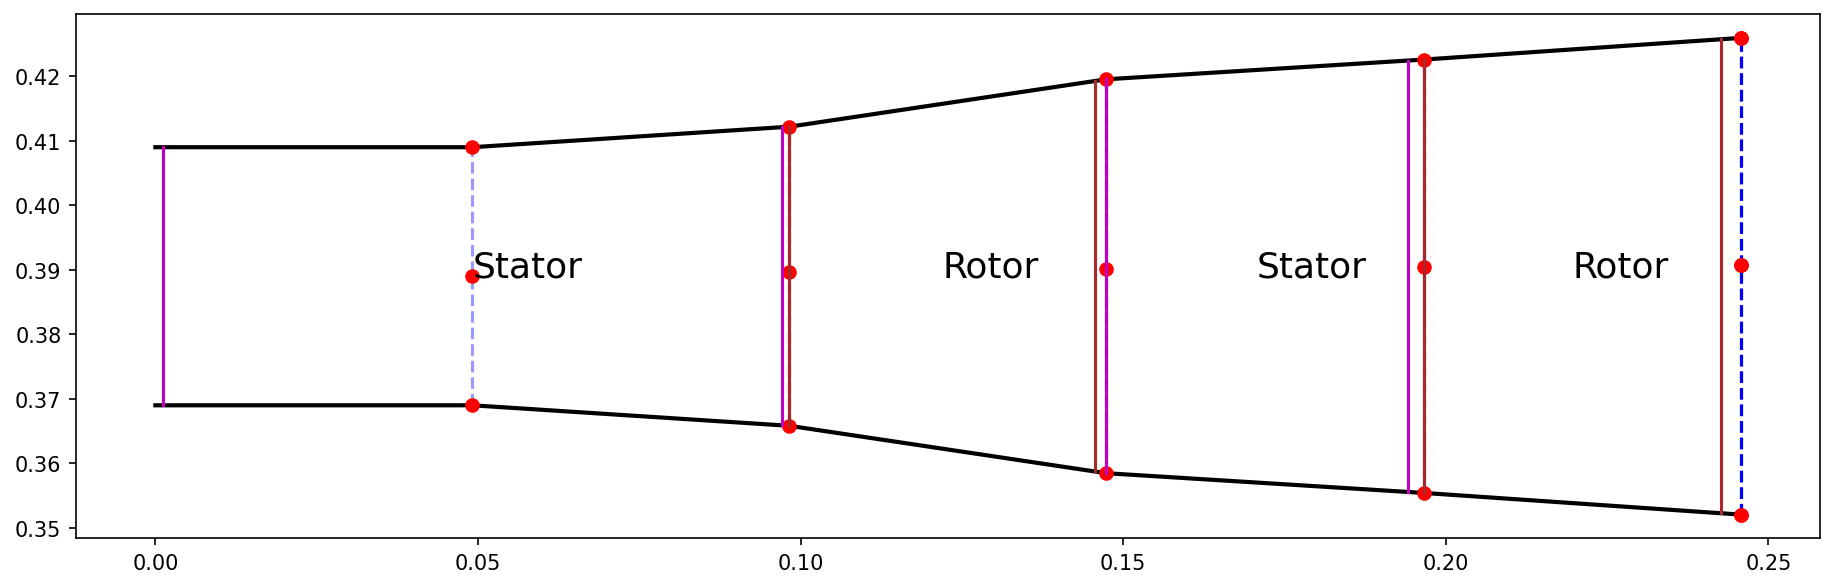

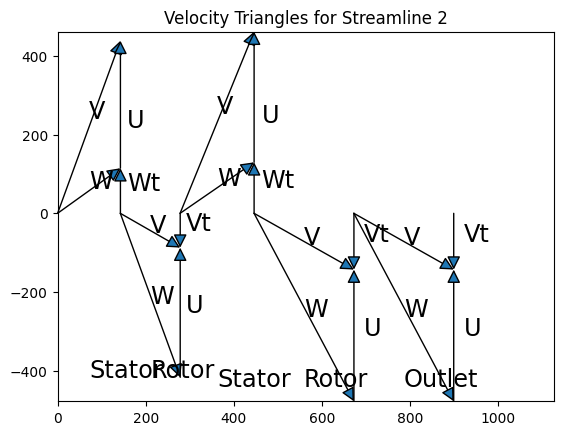

In [12]:
#%% Initialize the Spool
spool = TurbineSpool(passage=passage,
            rpm=Design_RPM,
            num_streamlines=3,
            massflow=massflow,
            rows=[inlet,stator1,rotor1,stator2,rotor2,outlet])
spool.fluid = fluid
spool.massflow_constraint = MassflowConstraint.BalanceMassFlow # Fixes the exit angle and changes degree of reaction
# spool.plot_geometry()
spool.solve() # This also initializes streamlines
spool.export_properties("optturb.json")
spool.plot()
spool.plot_velocity_triangles()
